In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 12.6 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which i

In [2]:
from datasets import load_dataset
# please also check this: https://huggingface.co/collections/laolao77/virft-datasets-67bc271b6f2833eccc0651df
# (we can use only the 4 classification datasets)
dataset = load_dataset('ajinkyakolhe112/cats_vs_dogs_classification_kaggle')
dataset

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/565 [00:00<?, ?B/s]

(…)-00000-of-00002-e0188125e40cdd17.parquet:   0%|          | 0.00/262M [00:00<?, ?B/s]

(…)-00001-of-00002-191fec05447fa590.parquet:   0%|          | 0.00/310M [00:00<?, ?B/s]

(…)-00000-of-00001-4f38aecb9bfc9d55.parquet:   0%|          | 0.00/285M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12500 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 12500
    })
})

In [3]:
dataset['train'].features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cat', 'dog', 'test'], id=None)}

In [9]:
from datasets import load_dataset

# Load the dataset
dataset = load_dataset('ajinkyakolhe112/cats_vs_dogs_classification_kaggle')

# Split the training data into train and test (let's say 20% for the test set)
train_test_split = dataset['train'].train_test_split(test_size=0.1, seed=42)

# Further split the training set to get a validation set (e.g., 10% of the training set)
train_val_split = train_test_split['train'].train_test_split(test_size=0.1, seed=42)

# Combine the splits into a new DatasetDict
final_dataset = {
    'train': train_val_split['train'],
    'val': train_val_split['test'],  # Validation set
    'test': train_test_split['test']  # Test set
}

# Display the structure of the final dataset
final_dataset

{'train': Dataset({
     features: ['image', 'label'],
     num_rows: 20250
 }),
 'val': Dataset({
     features: ['image', 'label'],
     num_rows: 2250
 }),
 'test': Dataset({
     features: ['image', 'label'],
     num_rows: 2500
 })}

In [10]:
train_ds = final_dataset["train"]
val_ds = final_dataset["val"]
test_ds = final_dataset["test"]

In [13]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=353x499>,
 'label': 1}

In [12]:
train_ds.features

{'image': Image(mode=None, decode=True, id=None),
 'label': ClassLabel(names=['cat', 'dog', 'test'], id=None)}

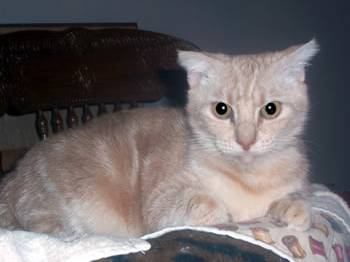

In [14]:
image = train_ds[1]['image']
image

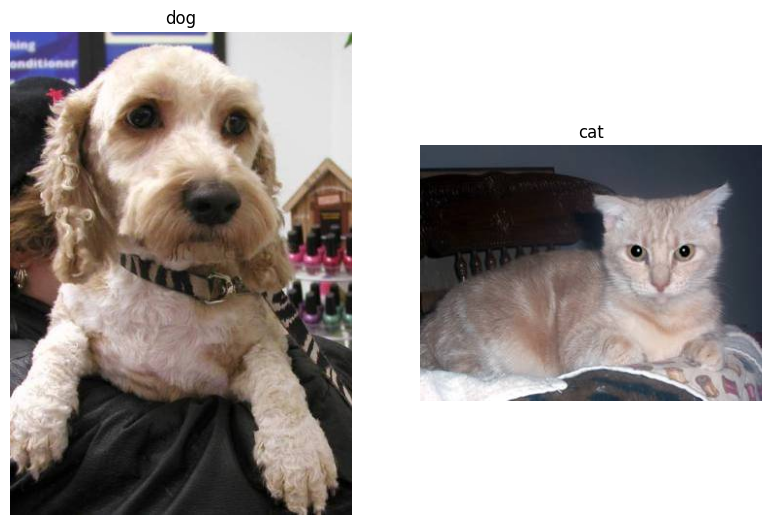

In [15]:
import matplotlib.pyplot as plt

# Initialize a set to keep track of shown labels
shown_labels = set()

# Initialize the figure for plotting
plt.figure(figsize=(15, 10))

# Loop through the dataset and plot the first image of each label
for i, sample in enumerate(train_ds):
    label = train_ds.features["label"].names[sample["label"]]
    if label not in shown_labels:
        plt.subplot(1, len(train_ds.features["label"].names), len(shown_labels) + 1)
        plt.imshow(sample["image"])
        plt.title(label)
        plt.axis("off")
        shown_labels.add(label)
        if len(shown_labels) == len(train_ds.features["label"].names):
            break

plt.show()

In [16]:
id2label = {id: label for id, label in enumerate(train_ds.features["label"].names)}
label2id = {label: id for id, label in id2label.items()}
id2label, id2label[train_ds[0]["label"]]

({0: 'cat', 1: 'dog', 2: 'test'}, 'dog')

In [17]:
from transformers import ViTImageProcessor

# https://huggingface.co/google/vit-base-patch16-224 (this is further fine-tuned)
# https://huggingface.co/google/vit-base-patch16-224-in21k (this one isnt fine-tuned further)

model_name = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_name)
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [18]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    ToTensor,
    Resize,
)

image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]

normalize = Normalize(mean=image_mean, std=image_std)

train_transforms = Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)
val_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)
test_transforms = Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [19]:
def apply_train_transforms(examples):
    examples["pixel_values"] = [train_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

In [20]:
train_ds.set_transform(apply_train_transforms)
val_ds.set_transform(apply_val_transforms)
test_ds.set_transform(apply_test_transforms)

In [21]:
import torch
from torch.utils.data import DataLoader


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}


train_dl = DataLoader(train_ds, collate_fn=collate_fn, batch_size=4)

In [22]:
batch = next(iter(train_dl))
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        print(k, v.shape)

pixel_values torch.Size([4, 3, 224, 224])
labels torch.Size([4])


In [40]:
from transformers import ViTForImageClassification
labels  = dataset['train'].features['label'].names
model = ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels),
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# !pip install --upgrade transformers

In [ ]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=1, # later, we can set higher to 2 or 3
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  weight_decay=0.01,
  lr_scheduler_type="cosine", # WE ONLY TWEAK HERE. TRY MULTIPLE SCHEDULERS
  warmup_steps=10,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to=[],
  load_best_model_at_end=True,
)

In [ ]:
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
)

trainer.train()

<ipython-input-20-995430cd73f9>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
10,2.011800,1.837836
20,1.648600,1.386359
30,1.317900,1.134033
40,1.127300,1.077644


TrainOutput(global_step=41, training_loss=1.519700957507622, metrics={'train_runtime': 52.3262, 'train_samples_per_second': 12.384, 'train_steps_per_second': 0.784, 'total_flos': 5.021750962697011e+16, 'train_loss': 1.519700957507622, 'epoch': 1.0})

In [ ]:
outputs = trainer.predict(test_ds)
print(outputs.metrics)

{'test_loss': 0.9735473394393921, 'test_runtime': 0.9238, 'test_samples_per_second': 86.602, 'test_steps_per_second': 10.825}


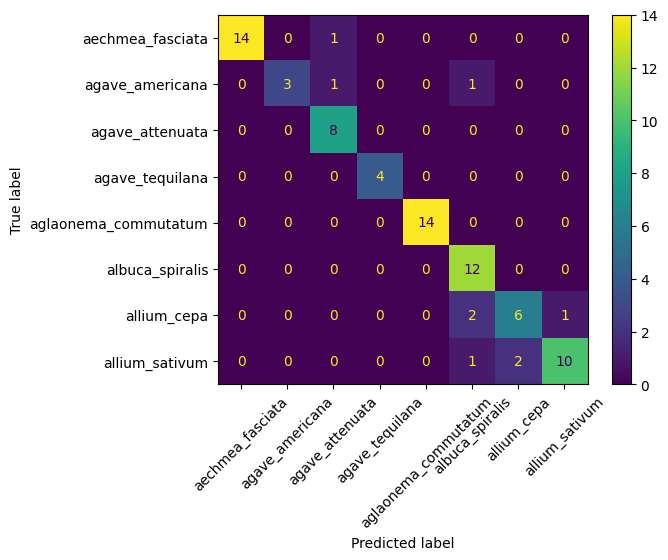

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(1)

labels = train_ds.features["label"].names
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
from sklearn.metrics import classification_report

target_names = id2label.values()

print(classification_report(y_true, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

    aechmea_fasciata       1.00      0.93      0.97        15
     agave_americana       1.00      0.60      0.75         5
     agave_attenuata       0.80      1.00      0.89         8
     agave_tequilana       1.00      1.00      1.00         4
aglaonema_commutatum       1.00      1.00      1.00        14
     albuca_spiralis       0.75      1.00      0.86        12
         allium_cepa       0.75      0.67      0.71         9
      allium_sativum       0.91      0.77      0.83        13

            accuracy                           0.89        80
           macro avg       0.90      0.87      0.88        80
        weighted avg       0.90      0.89      0.89        80



In [ ]:
from sklearn.metrics import accuracy_score

# Calculate the accuracy score
accuracy = accuracy_score(y_true, y_pred)

# Print the accuracy
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.89


#### ATTENTION VISUALIZATION

In [39]:
# from transformers import ViTImageProcessor, ViTForImageClassification

# Load the processor (for consistent image preprocessing).
processor = processor # already loaded above

# Load the fine-tuned model. This model now includes your updated weights.
model = ViTForImageClassification.from_pretrained(
    "./output-models/checkpoint-41",  # your saved fine-tuned model directory --> CHECK THE LATEST CHECKPOINT!!
    attn_implementation="eager"
)


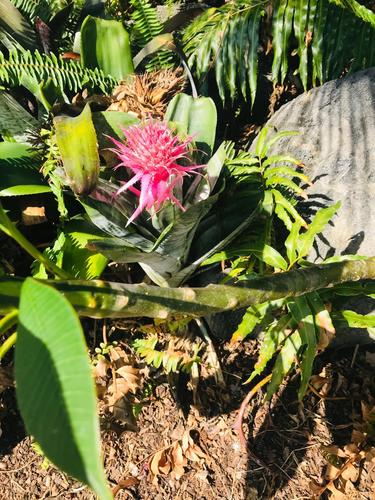

In [ ]:
test_image_visualize = test_ds[0]['image']
test_image_visualize

In [ ]:
image = test_image_visualize

In [ ]:
# Assume 'image' is a PIL.Image instance.
inputs = processor(images=test_image_visualize, return_tensors="pt")


In [ ]:
# Run the forward pass.
outputs = model(**inputs, output_attentions=True)
logits = outputs.logits

# Get the predicted class index.
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

# Get the attention maps.
attentions = outputs.attentions
print("Attention maps:", attentions)


Predicted class: aechmea_fasciata
Attention maps: (tensor([[[[8.0665e-01, 1.2777e-03, 1.7796e-03,  ..., 1.5094e-03,
           1.0455e-03, 8.5590e-04],
          [1.3613e-05, 9.9971e-01, 1.0851e-06,  ..., 2.6890e-08,
           6.9661e-10, 1.0727e-11],
          [2.9568e-05, 1.3654e-06, 9.9980e-01,  ..., 1.1617e-06,
           2.2228e-09, 4.1481e-09],
          ...,
          [2.4336e-05, 1.3570e-07, 2.6186e-06,  ..., 9.9986e-01,
           3.5459e-09, 8.9973e-10],
          [5.4155e-07, 2.5768e-11, 4.3622e-11,  ..., 1.0127e-10,
           1.0000e+00, 4.1240e-14],
          [7.3232e-06, 5.8982e-12, 1.2126e-09,  ..., 2.1909e-10,
           5.7293e-13, 9.9998e-01]],

         [[9.0450e-01, 5.5534e-04, 7.3451e-04,  ..., 4.7569e-04,
           5.1326e-04, 4.5193e-04],
          [1.1391e-01, 6.6250e-01, 6.1521e-03,  ..., 8.5149e-04,
           3.0753e-04, 5.3898e-05],
          [3.9415e-02, 1.0283e-03, 8.4993e-01,  ..., 3.9942e-04,
           4.1922e-05, 1.7739e-05],
          ...,
        

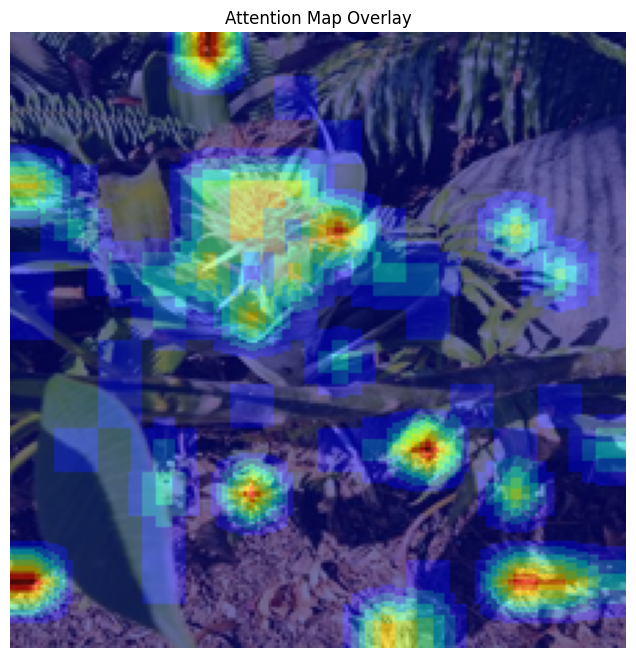

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter

# ----- Process Attention Map -----
# Get the attention from the last layer.
# Shape: (batch_size, num_heads, tokens, tokens)
last_attn = outputs.attentions[-1]

# Use the attention from the [CLS] token (token index 0) to all the patch tokens (skip index 0).
cls_attn = last_attn[0, :, 0, 1:]  # shape: (num_heads, tokens-1)

# Average the attention over all heads.
avg_attn = cls_attn.mean(dim=0).detach().cpu().numpy()  # shape: (tokens-1,)

# For a 224x224 image with 16x16 patches, the grid is 14x14 (since 224/16 = 14).
grid_size = int(np.sqrt(avg_attn.shape[0]))
attn_map = avg_attn.reshape(grid_size, grid_size)

# ----- Upsample Attention Map -----
# Convert the attention map to a PIL image for resizing.
attn_map_img = Image.fromarray((attn_map * 255).astype(np.uint8))
# Resize to the original image dimensions (here, 224x224).
attn_map_img = attn_map_img.resize((224, 224), resample=Image.BILINEAR)
# Convert back to numpy array and normalize between 0 and 1.
attn_map_np = np.array(attn_map_img) / 255.0

# Optionally, you can apply a blur for smoother visualization.
# attn_map_img = attn_map_img.filter(ImageFilter.GaussianBlur(radius=2))
# attn_map_np = np.array(attn_map_img) / 255.0

# ----- Prepare the Original Image for Display -----
if not isinstance(image, Image.Image):
    original_image = Image.fromarray(image)
else:
    original_image = image

# Resize the original image to match the attention map dimensions.
original_image = original_image.resize((224, 224))
original_np = np.array(original_image)

# ----- Visualization -----
plt.figure(figsize=(8, 8))
plt.imshow(original_np)
# Overlay the attention map with a colormap (e.g., 'jet') and some transparency.
plt.imshow(attn_map_np, cmap='jet', alpha=0.55)
plt.axis('off')
plt.title("Attention Map Overlay")
plt.show()


#### ATTENTION VISUALIZATION PER STEP

In [24]:
# !pip install --upgrade transformers
from transformers import TrainerCallback, EarlyStoppingCallback
import torch
import matplotlib.pyplot as plt
from scipy.ndimage import zoom
import os

class Attentionmapcallback(TrainerCallback):
    def __init__(self, feature_extractor, image, output_dir,total_epochs, device = 'cuda'):
        self.feature_extractor = feature_extractor
        self.image = image
        self.output_dir = output_dir
        self.total_epochs = total_epochs
        self.device = device
        os.makedirs(self.output_dir, exist_ok=True)

    def plt_attn(self, attentions, epoch, step , layer = 0, head = 0):

      attn = attentions[layer][0,head]  #.cpu().detach().numpy()
      cls_attn = attn[0,1:]
      nm_patch = cls_attn.shape[0]
      gid_size = int(np.sqrt(nm_patch))
      ##cls_attn = cls_attn.reshape(gid_size,gid_size)

      if gid_size * gid_size != nm_patch:
        print(f"skipping attn epoch {epoch}")
        return

      cls_attn = cls_attn.cpu().detach().numpy().reshape(gid_size,gid_size)

      if isinstance(self.image, np.ndarray):
        img_np = self.image
      else:
        img_np = np.array(self.image)

      attn_resized = zoom(cls_attn, (img_np.shape[0] / gid_size, img_np.shape[1] / gid_size))


      plt.figure(figsize=(8, 8))


      plt.imshow(self.image)
      plt.imshow(attn_resized, cmap = 'jet',  alpha=0.3)
      plt.axis('off')
      plt.title(f"Epoch {epoch}, Layer {layer}, Head {head}")
      plt.savefig(os.path.join(self.output_dir, f"step_{step}_epoch_{epoch}_layer_{layer}_head_{head}.png"))
      plt.close()



    def on_step_end(self, args, state, control, **kwargs):
      epoch = state.epoch
      step = state.global_step
      if step in [0, 5, 10,15,50,60,80,100,120]:
        model = kwargs['model']
        model.eval()
        inputs = self.feature_extractor(images=self.image, return_tensors="pt").to(self.device)
        with torch.no_grad():
          outputs = model(**inputs, output_attentions=True)
          attentions = outputs.attentions
          #self.plt_attn(attentions, int(epoch), int(step))
          self.plt_attn(attentions, int(epoch), int(step) ,layer = -1, head = -1)


In [26]:
from google.colab import drive #just for colab - comment it out if running locally
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=1, # later, we can set higher to 2 or 3
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  weight_decay=0.01,
  lr_scheduler_type="linear", # WE ONLY TWEAK HERE. TRY MULTIPLE SCHEDULERS
  warmup_steps=10,
  remove_unused_columns=False,
  push_to_hub=False,
  report_to=[],
  load_best_model_at_end=True,
)

In [43]:
attn_map_clbck = Attentionmapcallback(processor,
                                      test_ds[0]['image'],
                                      './attention_maps/' + str(train_args.lr_scheduler_type).split('.')[-1] ,
                                      train_args.num_train_epochs)
trainer = Trainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
    callbacks = [attn_map_clbck, EarlyStoppingCallback(early_stopping_patience = 4)]
)

trainer.train()

<ipython-input-43-8e0d13a37d08>:5: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
10,0.974700,0.576031
20,0.419200,0.170049
30,0.196100,0.187354
40,0.280100,0.110479
50,0.178600,0.110487
60,0.192200,0.273230
70,0.206600,0.125972
80,0.174000,0.068753
90,0.164700,0.075935
100,0.127100,0.073504


KeyboardInterrupt: 

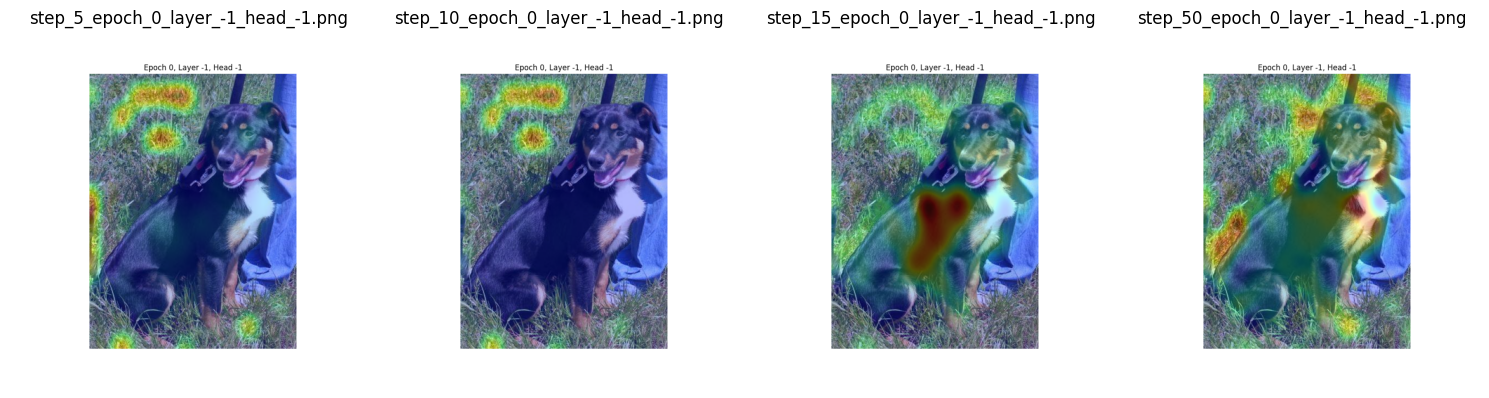

In [31]:
img_files = ['step_5_epoch_0_layer_-1_head_-1.png',
             'step_10_epoch_0_layer_-1_head_-1.png',
             'step_15_epoch_0_layer_-1_head_-1.png',
             'step_50_epoch_0_layer_-1_head_-1.png',
]

fig, axes = plt.subplots(1, len(img_files), figsize=(15, 5))

for i, img_file in enumerate(img_files):
    img_path = os.path.join('./attention_maps/COSINE', img_file)
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(img_files[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

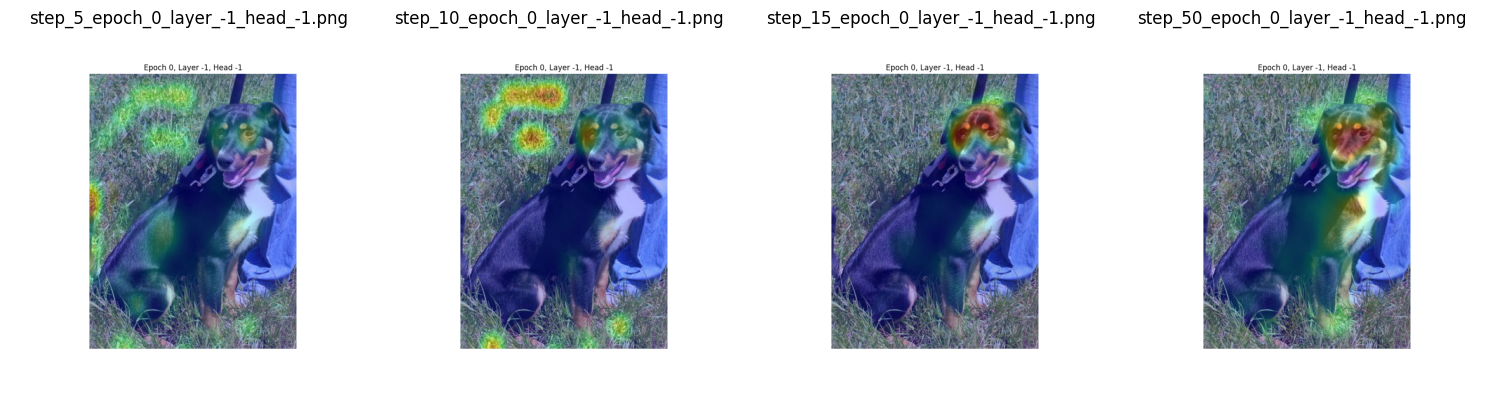

In [44]:
img_files = ['step_5_epoch_0_layer_-1_head_-1.png',
             'step_10_epoch_0_layer_-1_head_-1.png',
             'step_15_epoch_0_layer_-1_head_-1.png',
             'step_50_epoch_0_layer_-1_head_-1.png',
]

fig, axes = plt.subplots(1, len(img_files), figsize=(15, 5))

for i, img_file in enumerate(img_files):
    img_path = os.path.join('./attention_maps/LINEAR', img_file)
    img = plt.imread(img_path)
    axes[i].imshow(img)
    axes[i].set_title(img_files[i])
    axes[i].axis('off')

plt.tight_layout()
plt.show()

### Schedulers

In [ ]:
!pip install schedulefree

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer


import numpy as np
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}


BASE_LEARNING_RATE = 2e-4
BASE_NUM_EPOCHS = 1
BASE_BATCH_SIZE = 16
BASE_WARMUP_STEPS = 10
BASE_WEIGHT_DECAY = 0.01
FP16 = True
schedulers_to_test = ["linear",
                      "cosine", # What Jack set: original baseline
                      "polynomial",
                      # "cosine_with_restarts",
                      # "polynomial",
                      # "constant", #cloeset to not having a scheudler? (could use this or cosine as baseline if required)
                      # "constant_with_warmup",
                      ]

results = {}


In [ ]:
use_attn_per_step = False

print(f"Starting scheduler evaluation for: {schedulers_to_test}")
print("-" * 30)

for scheduler_name in schedulers_to_test:
    print(f"\n--- Testing Scheduler: {scheduler_name} ---")
    output_dir = f"./output-models-scheduler-{scheduler_name}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_dir=f"{output_dir}/logs",
        per_device_train_batch_size=BASE_BATCH_SIZE,
        per_device_eval_batch_size=BASE_BATCH_SIZE,
        eval_strategy="steps",
        logging_steps=10,
        eval_steps=20,
        num_train_epochs=BASE_NUM_EPOCHS,
        fp16=FP16,
        save_steps=20,
        learning_rate=BASE_LEARNING_RATE,
        lr_scheduler_type=scheduler_name,
        warmup_steps=BASE_WARMUP_STEPS,
        weight_decay=BASE_WEIGHT_DECAY,
        save_total_limit=1,
        remove_unused_columns=False,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        report_to=[],
    )

    print("Loading base pre-trained model...")
    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

    if use_attn_per_step:
      attn_map_clbck = Attentionmapcallback(processor,
                                      test_ds[0]['image'],
                                      './attention_maps/' + str(training_args.lr_scheduler_type).split('.')[-1] ,
                                      training_args.num_train_epochs)

      trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            data_collator=collate_fn,
            tokenizer=processor,
            compute_metrics=compute_metrics,
            callbacks = [attn_map_clbck]
        )

    else:

      trainer = Trainer(
          model=model,
          args=training_args,
          train_dataset=train_ds,
          eval_dataset=val_ds,
          data_collator=collate_fn,
          tokenizer=processor,
          compute_metrics=compute_metrics,
      )

    print(f"Starting training for scheduler: {scheduler_name}...")
    start_time = time.time()
    train_result = trainer.train()
    training_time = time.time() - start_time
    print(f"Training finished for {scheduler_name}. Time taken: {training_time:.2f} seconds")

    print(f"Evaluating on test set for scheduler: {scheduler_name}...")
    predict_output = trainer.predict(test_ds)
    test_metrics = predict_output.metrics
    print(f"Test Metrics for {scheduler_name}: {test_metrics}")

    results[scheduler_name] = {
        'test_metrics': test_metrics,
        'training_time': training_time,
        'log_history': trainer.state.log_history,
    }

    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n--- Evaluation Complete ---")

Starting scheduler evaluation for: ['linear', 'cosine', 'polynomial']
------------------------------

--- Testing Scheduler: linear ---
Loading base pre-trained model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-7376fc92e683>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training for scheduler: linear...


Step,Training Loss,Validation Loss,Accuracy
20,1.642100,1.371440,0.791667
40,1.009900,0.871870,0.819444
60,0.691800,0.666195,0.847222
80,0.597000,0.593475,0.847222
100,0.417800,0.539566,0.861111
120,0.376100,0.474304,0.875000


Training finished for linear. Time taken: 89.19 seconds
Evaluating on test set for scheduler: linear...


Test Metrics for linear: {'test_loss': 0.45694732666015625, 'test_accuracy': 0.875, 'test_runtime': 0.7282, 'test_samples_per_second': 109.867, 'test_steps_per_second': 6.867}

--- Testing Scheduler: cosine ---
Loading base pre-trained model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-7376fc92e683>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training for scheduler: cosine...


Step,Training Loss,Validation Loss,Accuracy
20,1.687300,1.406291,0.708333
40,1.001700,0.834178,0.833333
60,0.644500,0.629400,0.833333
80,0.551000,0.523888,0.875000
100,0.378800,0.490251,0.902778
120,0.363500,0.466168,0.916667


Training finished for cosine. Time taken: 82.50 seconds
Evaluating on test set for scheduler: cosine...


Test Metrics for cosine: {'test_loss': 0.4255966246128082, 'test_accuracy': 0.9, 'test_runtime': 0.8808, 'test_samples_per_second': 90.83, 'test_steps_per_second': 5.677}

--- Testing Scheduler: polynomial ---
Loading base pre-trained model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-31-7376fc92e683>:40: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training for scheduler: polynomial...


Step,Training Loss,Validation Loss,Accuracy
20,1.688200,1.408257,0.722222
40,1.014300,0.855577,0.847222
60,0.660200,0.665702,0.847222
80,0.555000,0.586507,0.861111
100,0.382800,0.552309,0.847222
120,0.358800,0.480320,0.902778


Training finished for polynomial. Time taken: 86.18 seconds
Evaluating on test set for scheduler: polynomial...


Test Metrics for polynomial: {'test_loss': 0.4376266598701477, 'test_accuracy': 0.8875, 'test_runtime': 0.9008, 'test_samples_per_second': 88.809, 'test_steps_per_second': 5.551}

--- Evaluation Complete ---



--- Analyzing Results ---

--- Raw Metrics per Scheduler ---
linear: {'test_loss': 0.45694732666015625, 'test_accuracy': 0.875, 'test_runtime': 0.7282, 'test_samples_per_second': 109.867, 'test_steps_per_second': 6.867}
cosine: {'test_loss': 0.4255966246128082, 'test_accuracy': 0.9, 'test_runtime': 0.8808, 'test_samples_per_second': 90.83, 'test_steps_per_second': 5.677}
polynomial: {'test_loss': 0.4376266598701477, 'test_accuracy': 0.8875, 'test_runtime': 0.9008, 'test_samples_per_second': 88.809, 'test_steps_per_second': 5.551}

--- Performance Summary ---
 Scheduler  Test Accuracy  Test Loss  Training Time (s)
    linear         0.8750   0.456947          89.186220
    cosine         0.9000   0.425597          82.502147
polynomial         0.8875   0.437627          86.176236

--- Plotting Training Loss ---


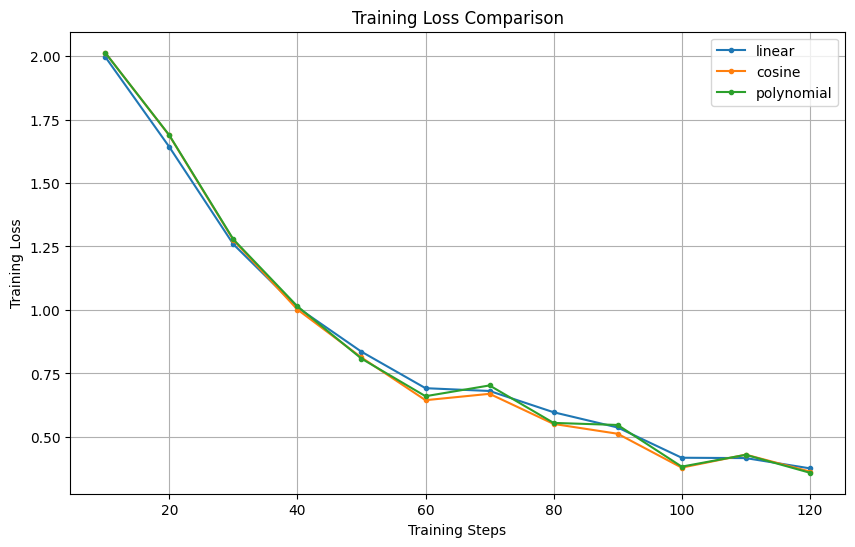


--- Plotting Validation Loss ---


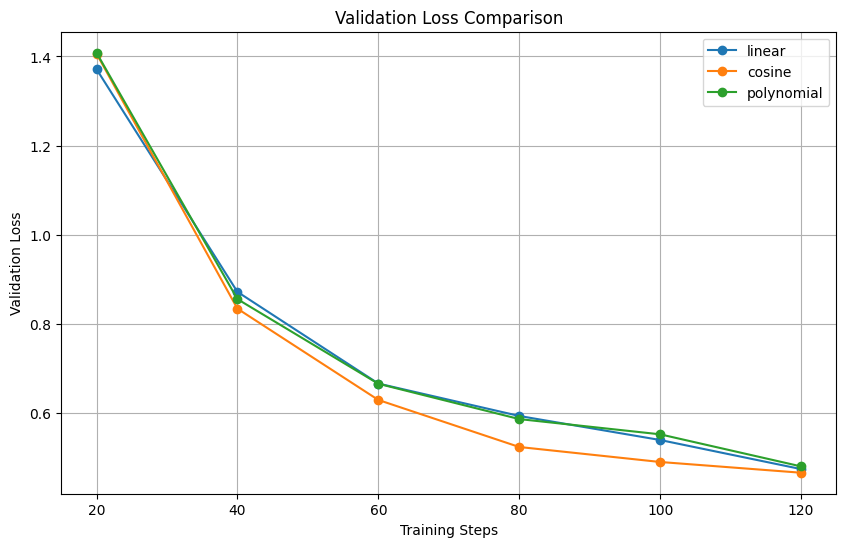


--- Plotting Validation Accuracy ---


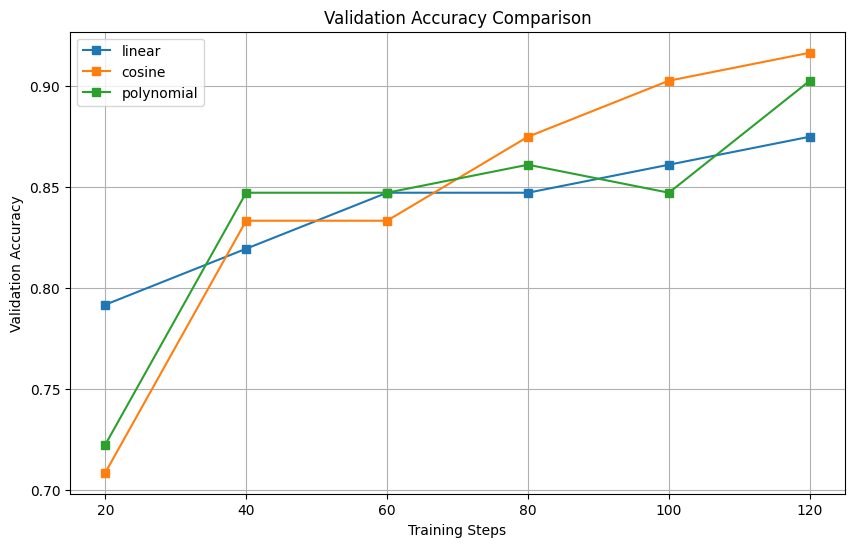

In [ ]:
print("\n--- Analyzing Results ---")

summary_data = []
print("\n--- Raw Metrics per Scheduler ---")
for name, data in results.items(): #
    if 'test_metrics' not in data:
        print(f"WARNING: Missing 'test_metrics' for {name}")
        continue
    metrics = data['test_metrics']
    print(f"{name}: {metrics}")
    accuracy = metrics.get('test_accuracy', metrics.get('eval_accuracy', None))
    loss = metrics.get('test_loss', metrics.get('eval_loss', None))
    summary_data.append({
        'Scheduler': name,
        'Test Accuracy': accuracy,
        'Test Loss': loss,
        'Training Time (s)': data.get('training_time', None)
    })

summary_df = pd.DataFrame(summary_data)
print("\n--- Performance Summary ---")
if not summary_df.empty:
    print(summary_df.to_string(index=False))
else:
    print("No results to display in summary table.")

# Training Loss
print("\n--- Plotting Training Loss ---")
plt.figure(figsize=(10, 6))
plotted_something_train_loss = False
for name, data in results.items():
    log_history = data.get('log_history', [])
    steps = [log['step'] for log in log_history if 'loss' in log and 'eval_loss' not in log and 'train_runtime' not in log]
    losses = [log['loss'] for log in log_history if 'loss' in log and 'eval_loss' not in log and 'train_runtime' not in log]
    if steps:
        plt.plot(steps, losses, label=name, marker='.', linestyle='-')
        plotted_something_train_loss = True
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison")
if plotted_something_train_loss: plt.legend()
plt.grid(True)
plt.show()

# Validation Loss
print("\n--- Plotting Validation Loss ---")
plt.figure(figsize=(10, 6))
plotted_something_eval_loss = False
for name, data in results.items():
    log_history = data.get('log_history', [])
    eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]
    eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    if eval_steps:
        plt.plot(eval_steps, eval_losses, label=name, marker='o', linestyle='-')
        plotted_something_eval_loss = True
plt.xlabel("Training Steps")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison")
if plotted_something_eval_loss: plt.legend()
plt.grid(True)
plt.show()

#Validation Accuracy
print("\n--- Plotting Validation Accuracy ---")
plt.figure(figsize=(10, 6))
plotted_something_eval_acc = False
for name, data in results.items():
    log_history = data.get('log_history', [])
    eval_steps = [log['step'] for log in log_history if 'eval_accuracy' in log]
    eval_accs = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
    if eval_steps:
        plt.plot(eval_steps, eval_accs, label=name, marker='s', linestyle='-')
        plotted_something_eval_acc = True
plt.xlabel("Training Steps")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison")
if plotted_something_eval_acc: plt.legend()
plt.grid(True)
plt.show()

### Optimizers

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from transformers import ViTImageProcessor, ViTForImageClassification, TrainingArguments, Trainer

#Configuration -keep consistent with scheduler test(!)
print("--- Optimizer Test Configuration ---")
BASE_LEARNING_RATE = 2e-4
BASE_NUM_EPOCHS = 1
BASE_BATCH_SIZE = 16
BASE_WARMUP_STEPS = 10
BASE_WEIGHT_DECAY = 0.01
FP16 = True

FIXED_SCHEDULER = "cosine" # Kindly reminder: keep consistent scheduler when testing/runing both sets of code.
print(f"Base LR: {BASE_LEARNING_RATE}, Epochs: {BASE_NUM_EPOCHS}, BS: {BASE_BATCH_SIZE}")
print(f"Warmup Steps: {BASE_WARMUP_STEPS}, Weight Decay: {BASE_WEIGHT_DECAY}")
print(f"Using FIXED Scheduler: {FIXED_SCHEDULER}")
print("-" * 30)

#Basic List of optimizers to test. TODO:Strech goal: add more & RL methods
optimizers_to_test = [
    "adamw_torch",
    # "adafactor",
    # "sgd",
    # "adagrad",
    # "rmsprop",
    "schedule_free_adamw",
    # more at: https://huggingface.co/docs/transformers/v4.51.3/en/main_classes/optimizer_schedules#transformers.SchedulerType
]
print(f"Optimizers to test: {optimizers_to_test}")

optimizer_results = {}

from sklearn.metrics import accuracy_score
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = np.argmax(predictions, axis=1)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc}

--- Optimizer Test Configuration ---
Base LR: 0.0002, Epochs: 1, BS: 16
Warmup Steps: 10, Weight Decay: 0.01
Using FIXED Scheduler: cosine
------------------------------
Optimizers to test: ['adamw_torch', 'schedule_free_adamw']


In [ ]:
print(f"\nStarting optimizer evaluation for: {optimizers_to_test}")
print("-" * 30)

for optimizer_name in optimizers_to_test:
    print(f"\n--- Testing Optimizer: {optimizer_name} ---")
    output_dir = f"./output-models-optimizer-{optimizer_name}"

    training_args = TrainingArguments(
        output_dir=output_dir,
        logging_dir=f"{output_dir}/logs",
        per_device_train_batch_size=BASE_BATCH_SIZE,
        per_device_eval_batch_size=BASE_BATCH_SIZE,
        eval_strategy="steps",
        logging_steps=10,
        eval_steps=20,
        num_train_epochs=BASE_NUM_EPOCHS,
        fp16=FP16,
        save_steps=20,
        learning_rate=BASE_LEARNING_RATE,
        optim=optimizer_name,
        lr_scheduler_type=FIXED_SCHEDULER,
        warmup_steps=BASE_WARMUP_STEPS,
        weight_decay=BASE_WEIGHT_DECAY,
        save_total_limit=1,
        remove_unused_columns=False,
        load_best_model_at_end=True,
        metric_for_best_model="eval_accuracy",
        greater_is_better=True,
        report_to=[],
    )

    print("Loading base pre-trained model...")
    model = ViTForImageClassification.from_pretrained(
        model_name,
        num_labels=len(labels),
        id2label=id2label,
        label2id=label2id,
        ignore_mismatched_sizes=True,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        data_collator=collate_fn,
        tokenizer=processor,
        compute_metrics=compute_metrics,
    )

    print(f"Starting training for optimizer: {optimizer_name}...")
    start_time = time.time()
    train_result = trainer.train()
    training_time = time.time() - start_time
    print(f"Training finished for {optimizer_name}. Time taken: {training_time:.2f} seconds")

    print(f"Evaluating on test set for optimizer: {optimizer_name}...")
    predict_output = trainer.predict(test_ds)
    test_metrics = predict_output.metrics
    print(f"Test Metrics for {optimizer_name}: {test_metrics}")

    optimizer_results[optimizer_name] = {
        'test_metrics': test_metrics,
        'training_time': training_time,
        'log_history': trainer.state.log_history,
    }

    del model, trainer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n--- Optimizer Evaluation Complete ---")



Starting optimizer evaluation for: ['adamw_torch', 'schedule_free_adamw']
------------------------------

--- Testing Optimizer: adamw_torch ---
Loading base pre-trained model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-78721820a322>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training for optimizer: adamw_torch...


Step,Training Loss,Validation Loss,Accuracy
20,1.641600,1.386624,0.791667
40,1.131600,1.073161,0.833333


Training finished for adamw_torch. Time taken: 33.14 seconds
Evaluating on test set for optimizer: adamw_torch...


Test Metrics for adamw_torch: {'test_loss': 1.010198950767517, 'test_accuracy': 0.8625, 'test_runtime': 2.1007, 'test_samples_per_second': 38.083, 'test_steps_per_second': 2.38}

--- Testing Optimizer: schedule_free_adamw ---
Loading base pre-trained model...


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-27-78721820a322>:41: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting training for optimizer: schedule_free_adamw...


Step,Training Loss,Validation Loss,Accuracy
20,1.762900,1.553880,0.722222
40,1.239400,1.204915,0.763889


Training finished for schedule_free_adamw. Time taken: 35.00 seconds
Evaluating on test set for optimizer: schedule_free_adamw...


Test Metrics for schedule_free_adamw: {'test_loss': 1.1358153820037842, 'test_accuracy': 0.85, 'test_runtime': 0.7455, 'test_samples_per_second': 107.317, 'test_steps_per_second': 6.707}

--- Optimizer Evaluation Complete ---



--- Analyzing Optimizer Results ---

--- Raw Metrics per Optimizer ---
adamw_torch: {'test_loss': 1.010198950767517, 'test_accuracy': 0.8625, 'test_runtime': 2.1007, 'test_samples_per_second': 38.083, 'test_steps_per_second': 2.38}
schedule_free_adamw: {'test_loss': 1.1358153820037842, 'test_accuracy': 0.85, 'test_runtime': 0.7455, 'test_samples_per_second': 107.317, 'test_steps_per_second': 6.707}

--- Optimizer Performance Summary ---
          Optimizer  Test Accuracy  Test Loss  Training Time (s)
        adamw_torch         0.8625   1.010199          33.140824
schedule_free_adamw         0.8500   1.135815          35.002057

--- Plotting Training Loss (Optimizers) ---


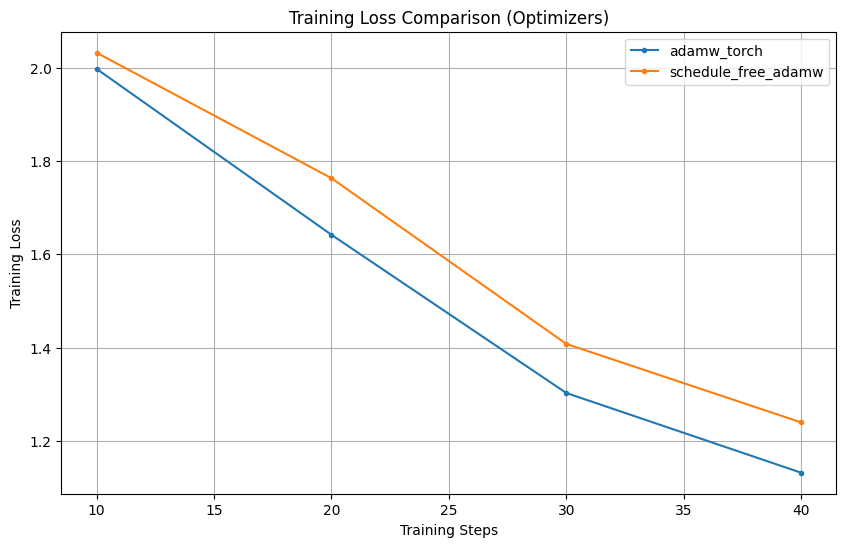


--- Plotting Validation Loss (Optimizers) ---


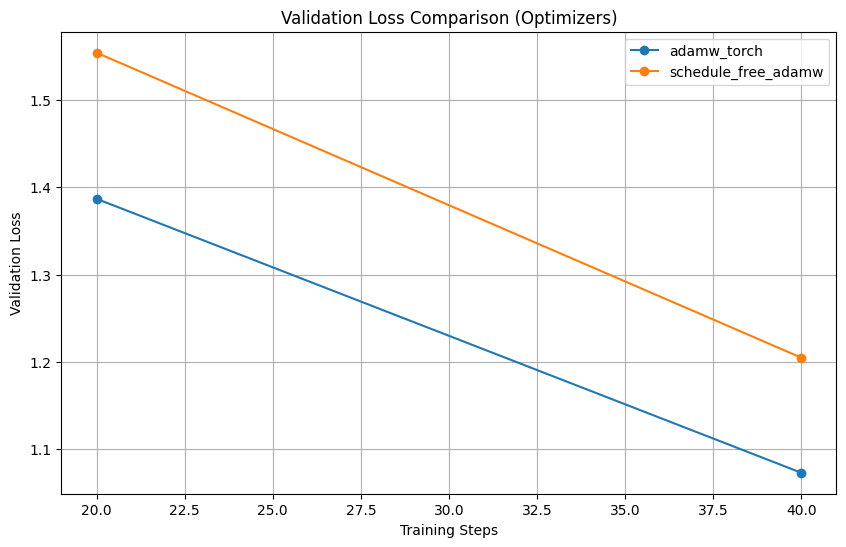


--- Plotting Validation Accuracy (Optimizers) ---


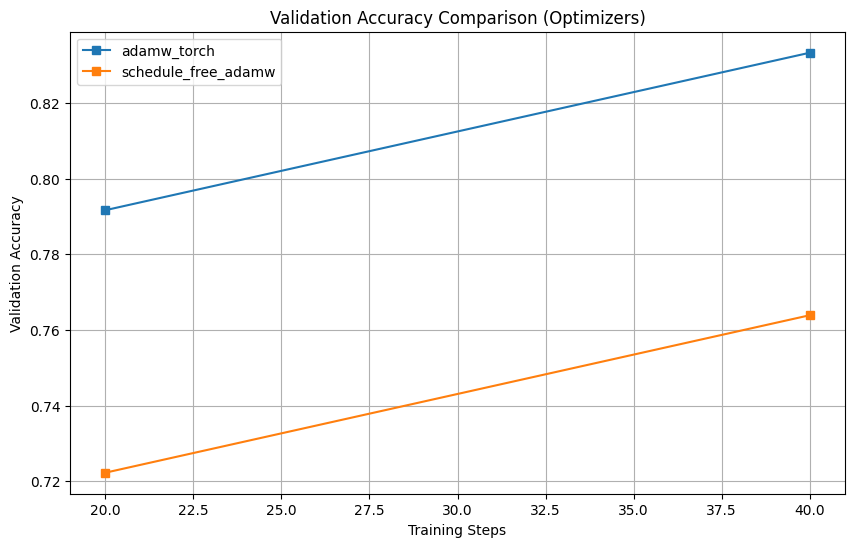

In [ ]:
print("\n--- Analyzing Optimizer Results ---")

summary_data_opt = []
print("\n--- Raw Metrics per Optimizer ---")
for name, data in optimizer_results.items():
    if 'test_metrics' not in data:
        print(f"WARNING: Missing 'test_metrics' for {name}")
        continue
    metrics = data['test_metrics']
    print(f"{name}: {metrics}")
    accuracy = metrics.get('test_accuracy', metrics.get('eval_accuracy', None))
    loss = metrics.get('test_loss', metrics.get('eval_loss', None))
    summary_data_opt.append({
        'Optimizer': name,
        'Test Accuracy': accuracy,
        'Test Loss': loss,
        'Training Time (s)': data.get('training_time', None)
    })

summary_df_opt = pd.DataFrame(summary_data_opt)
print("\n--- Optimizer Performance Summary ---")
if not summary_df_opt.empty:
    print(summary_df_opt.to_string(index=False))
else:
    print("No optimizer results to display in summary table.")

#Training Loss
print("\n--- Plotting Training Loss (Optimizers) ---")
plt.figure(figsize=(10, 6))
plotted_something_train_loss = False
for name, data in optimizer_results.items():
    log_history = data.get('log_history', [])
    steps = [log['step'] for log in log_history if 'loss' in log and 'eval_loss' not in log and 'train_runtime' not in log]
    losses = [log['loss'] for log in log_history if 'loss' in log and 'eval_loss' not in log and 'train_runtime' not in log]
    if steps:
        plt.plot(steps, losses, label=name, marker='.', linestyle='-')
        plotted_something_train_loss = True
plt.xlabel("Training Steps")
plt.ylabel("Training Loss")
plt.title("Training Loss Comparison (Optimizers)")
if plotted_something_train_loss: plt.legend()
plt.grid(True)
plt.show()

# Validation Loss
print("\n--- Plotting Validation Loss (Optimizers) ---")
plt.figure(figsize=(10, 6))
plotted_something_eval_loss = False
for name, data in optimizer_results.items():
    log_history = data.get('log_history', [])
    eval_steps = [log['step'] for log in log_history if 'eval_loss' in log]
    eval_losses = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
    if eval_steps:
        plt.plot(eval_steps, eval_losses, label=name, marker='o', linestyle='-')
        plotted_something_eval_loss = True
plt.xlabel("Training Steps")
plt.ylabel("Validation Loss")
plt.title("Validation Loss Comparison (Optimizers)")
if plotted_something_eval_loss: plt.legend()
plt.grid(True)
plt.show()

#Validation Accuracy
print("\n--- Plotting Validation Accuracy (Optimizers) ---")
plt.figure(figsize=(10, 6))
plotted_something_eval_acc = False
for name, data in optimizer_results.items():
    log_history = data.get('log_history', [])
    eval_steps = [log['step'] for log in log_history if 'eval_accuracy' in log]
    eval_accs = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]
    if eval_steps:
        plt.plot(eval_steps, eval_accs, label=name, marker='s', linestyle='-')
        plotted_something_eval_acc = True
plt.xlabel("Training Steps")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy Comparison (Optimizers)")
if plotted_something_eval_acc: plt.legend()
plt.grid(True)
plt.show()


# Custom Scheduler

In [ ]:
from torch.optim.lr_scheduler import LambdaLR
import math

def get_custom_cyclic_scheduler(optimizer,
                                schedule_steps,
                                schedule_funcs):

  phase_ends = [sum(schedule_steps[:i]) for i in range(1, len(schedule_steps) + 1)]

  def lr_lambda(current_step):
    phase_idx = next((i for i, end in enumerate(phase_ends) if current_step < end), len(schedule_steps) - 1)
    phase_start = 0 if phase_idx == 0 else phase_ends[phase_idx - 1]
    phase_progress = current_step - phase_start
    phase_total = schedule_steps[phase_idx]
    return schedule_funcs[phase_idx](phase_progress, phase_total)

  return LambdaLR(optimizer, lr_lambda)


In [ ]:
steps_per_epoch = int(np.ceil(len(train_ds)/train_args.per_device_train_batch_size))
print(f"Steps per epoch: {steps_per_epoch}")

In [ ]:
from transformers import TrainingArguments, Trainer


def linear_phase(step,total): return step/total
def cosine_phase(step, total): return 0.5 * (1 + math.cos(math.pi * step / total))
def exp_decay_phase(step, total): return 0.95**step

schedule_steps = [15,30,41]

schedule_funcs = [linear_phase, cosine_phase, exp_decay_phase]


class customLRSchedulerTrainer(Trainer):


  def create_scheduler(self, num_training_steps: int, optimizer=None):
    if self.lr_scheduler is None:
      self.lr_scheduler = get_custom_cyclic_scheduler(optimizer = optimizer if optimizer is not None else self.optimizer,
                                                      schedule_steps = schedule_steps,
                                                      schedule_funcs = schedule_funcs)


    return self.lr_scheduler








In [ ]:
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=1, # later, we can set higher to 2 or 3
  fp16=True,
  save_steps=10,
  eval_steps=10,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  weight_decay=0.01,
  #lr_scheduler_type="cosine", # WE ONLY TWEAK HERE. TRY MULTIPLE SCHEDULERS
  #warmup_steps=10,
  optim = 'sgd',
  remove_unused_columns=False,
  push_to_hub=False,
  report_to=[],
  load_best_model_at_end=True,
)

In [ ]:
attn_map_clbck = Attentionmapcallback(processor,
                                      test_ds[0]['image'],
                                      './attention_maps/' + str(train_args.lr_scheduler_type).split('.')[-1] ,
                                      train_args.num_train_epochs)

trainer = customLRSchedulerTrainer(
    model,
    train_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    tokenizer=processor,
    callbacks = [attn_map_clbck, EarlyStoppingCallback(early_stopping_patience = 4)]
)

In [ ]:
trainer.train()